In [1]:
import pandas as pd
import numpy as np
import tensorflow_data_validation as tfdv
from matplotlib import pyplot as plt
from heatmap import heatmap, corrplot
from soiltexture import getTexture

import warnings
warnings.filterwarnings("ignore")

In [2]:
Adults = pd.read_csv("Adults.csv")
Swarms  = pd.read_csv("Swarms.csv")
Hoppers = pd.read_csv("Hoppers.csv")
Ecology = pd.read_csv("Ecology.csv")
Control_Operations = pd.read_csv("Control_Operations.csv")

In [3]:
fao_data = pd.read_csv("fao_data_with_isric_raw.csv")

#convert date format from onbject to pandas datetime
date_columns = ['STARTDATE', 'FINISHDATE', 'CTLSTDATE', 'CTLFNDATE']
fao_data[date_columns] = fao_data[date_columns].apply(pd.to_datetime)

### Classifying Soil Texture Using USDA soil classification triangle

<img src="soil_triangle.jpg">

In [4]:
isric_bucketized_data = fao_data[[
    'TIME',
    'month',
    'day',
    'year',
    'lat_bucket_id',
    'lon_bucket_id',
    'date',
    'lat',
    'lon',
    'clay_0-5cm_mean',
    'clay_5-15cm_mean',
    'sand_0-5cm_mean',
    'sand_5-15cm_mean',
    'silt_0-5cm_mean',
    'silt_5-15cm_mean'
]]

In [5]:
isric_bucketized_data["sum_soil_profile"] = isric_bucketized_data[[
    'clay_5-15cm_mean',
    'sand_5-15cm_mean',
    'silt_5-15cm_mean'
]].sum(1)

isric_bucketized_data['clay_5-15cm_percent'] = isric_bucketized_data['clay_5-15cm_mean']/isric_bucketized_data['sum_soil_profile']
isric_bucketized_data['sand_5-15cm_percent'] = isric_bucketized_data['sand_5-15cm_mean']/isric_bucketized_data['sum_soil_profile']
isric_bucketized_data['silt_5-15cm_percent'] = isric_bucketized_data['silt_5-15cm_mean']/isric_bucketized_data['sum_soil_profile']

In [7]:
soil_profiles = []
for sand, clay in zip(isric_bucketized_data['sand_5-15cm_percent'], isric_bucketized_data['clay_5-15cm_percent']):
    try:
        soil_pf = getTexture(int(sand*100), int(clay*100))
        if soil_pf is None:
            soil_profiles.append(np.nan)
        else:
            soil_profiles.append(soil_pf)
    except:
        soil_profiles.append(np.nan)

isric_bucketized_data['soil profile'] = soil_profiles

# Merge Data

In [11]:
resx, resy = (0.01, 0.01)

lat_to_bucket_id = lambda x: int((x+90)/resy)
lon_to_bucket_id = lambda x: int((x+180)/resx)

bucket_id_to_lat = lambda x: (x*resy) - 90
bucket_id_to_lon = lambda x: (x*resx) - 180

locusts_data = pd.concat([Adults, Hoppers, Swarms])
locusts_data["STARTDATE"] = locusts_data["STARTDATE"].apply(pd.to_datetime)
locusts_data['yearmonth']= locusts_data['STARTDATE'].dt.year*100+ locusts_data['STARTDATE'].dt.month

ecology = Ecology
ecology["STARTDATE"] = ecology["STARTDATE"].apply(pd.to_datetime)
ecology['yearmonth']= ecology['STARTDATE'].dt.year*100+ ecology['STARTDATE'].dt.month

ecology['lat_bucket_id'] = ecology['Y'].apply(lat_to_bucket_id)
ecology['lon_bucket_id'] = ecology['X'].apply(lon_to_bucket_id)

locusts_data['lat_bucket_id'] = locusts_data['Y'].apply(lat_to_bucket_id)
locusts_data['lon_bucket_id'] = locusts_data['X'].apply(lon_to_bucket_id)

In [12]:
locusts_data = pd.merge(locusts_data, isric_bucketized_data[['lat_bucket_id', 'lon_bucket_id', 'soil profile']], how="left", on=['lat_bucket_id', 'lon_bucket_id'])
data_with_ecology = pd.merge(locusts_data, ecology[['yearmonth', 'lat_bucket_id', 'lon_bucket_id', 'SOILMOIST', 'NATVEGCAT',
       'NATVEGDEN', 'CULTVEGCAT', 'IRRIGATION']], how="left", on=['yearmonth', 'lat_bucket_id', 'lon_bucket_id'])

# Visualizations

### Distribution of Reliability Column

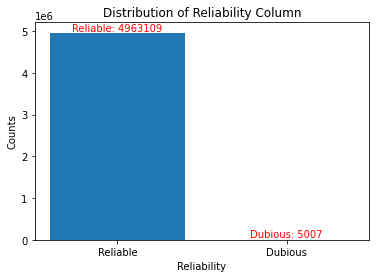

In [13]:
reliability = data_with_ecology["REPRELIAB"].dropna().value_counts()
fig, ax = plt.subplots()

labels = ["Reliable", "Dubious"]

ax.bar(list(reliability.index), list(reliability))
ax.set_ylabel("Counts")
ax.set_xlabel("Reliability")
ax.set_xticks(reliability.index)
ax.set_xticklabels(labels)

ax.set_title("Distribution of Reliability Column")

rects = ax.patches
counts = [int(x.get_height()) for x in rects]

for rect, label, count in zip(rects, labels, counts):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height+5, f"{label}: {count}",
            ha='center', va='bottom', color="red")
    
plt.show()

### Distribution of Confirmation Column

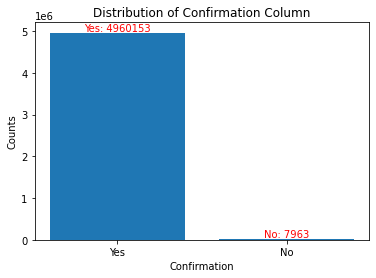

In [18]:
confirmation = data_with_ecology["CONFIRMATN"].dropna().value_counts()
fig, ax = plt.subplots()

labels = ["Yes", "No"]

ax.bar(list(confirmation.index), list(confirmation))
ax.set_ylabel("Counts")
ax.set_xlabel("Confirmation")
ax.set_xticks(confirmation.index)
ax.set_xticklabels(labels)

ax.set_title("Distribution of Confirmation Column")

rects = ax.patches
counts = [int(x.get_height()) for x in rects]

for rect, label, count in zip(rects, labels, counts):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height+5, f"{label}: {count}",
            ha='center', va='bottom', color="red")
plt.show()

### Distribution of Locust Present Column

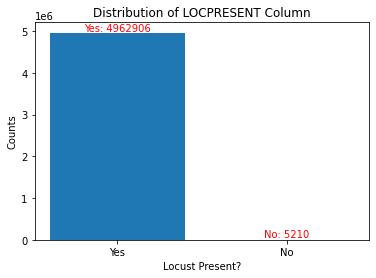

In [19]:
locust_present = data_with_ecology["LOCPRESENT"].dropna().value_counts()
fig, ax = plt.subplots()

labels = ["Yes", "No"]

ax.bar(list(locust_present.index), list(locust_present))
ax.set_ylabel("Counts")
ax.set_xlabel("Locust Present?")
ax.set_xticks(locust_present.index)
ax.set_xticklabels(labels)

ax.set_title("Distribution of LOCPRESENT Column")

rects = ax.patches
counts = [int(x.get_height()) for x in rects]

for rect, label, count in zip(rects, labels, counts):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height+5, f"{label}: {count}",
            ha='center', va='bottom', color="red")
    
plt.show()

### Distribution of Breeding Column

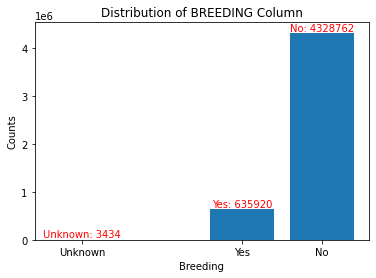

In [20]:
breeding = data_with_ecology["BREEDING"].dropna().value_counts() #[(fao_data["BREEDING"] == 1.) | (fao_data["BREEDING"] == 2.)]
fig, ax = plt.subplots()

labels = ["No", "Yes", "Unknown"]

ax.bar(list(breeding.index), list(breeding))
ax.set_ylabel("Counts")
ax.set_xlabel("Breeding")
ax.set_xticks(breeding.index)
ax.set_xticklabels(labels)

ax.set_title("Distribution of BREEDING Column")

rects = ax.patches
rects = [rects[0], rects[1], rects[2]]
counts = [int(x.get_height()) for x in rects]

for rect, label, count in zip(rects, labels, counts):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height+5, f"{label}: {count}",
            ha='center', va='bottom', color="red")
    
plt.show()

In [30]:
data_with_ecology["BREEDING"].value_counts()

 2    4328762
 1     635920
-1       3434
Name: BREEDING, dtype: int64

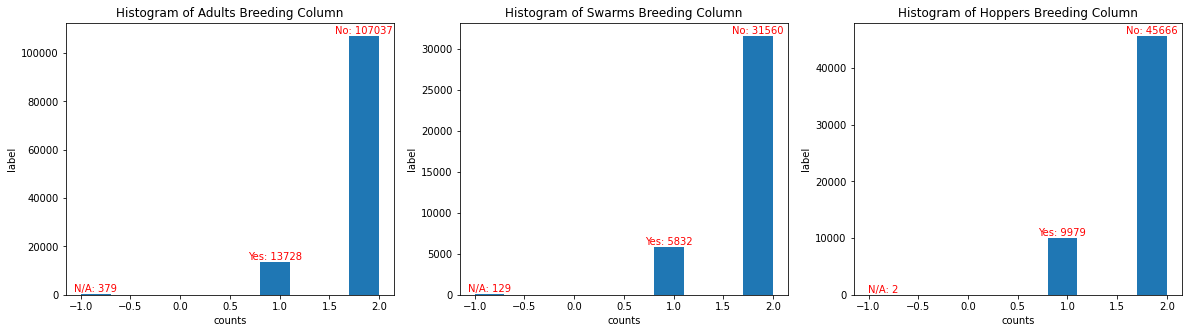

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(20,5))

axs = axs.flatten()

for data, name, ax in zip([Adults, Swarms, Hoppers], ["Adults", "Swarms", "Hoppers"], axs):
    ax.hist(data["BREEDING"])

    # Set title
    ax.set_title(f"Histogram of {name} Breeding Column")

    # adding labels
    ax.set_xlabel('counts')
    ax.set_ylabel('label')

    # Make some labels.
    rects = ax.patches
    labels = ["N/A", "Yes", "No"]

    rects = [rects[0], rects[6], rects[9]]
    counts = [int(x.get_height()) for x in rects]
    labels = [f"{label}: {count}" for label, count in zip(labels, counts)]

    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height+5, label,
                ha='center', va='bottom', color="red")

plt.show()

### Distribution of Soil Texture

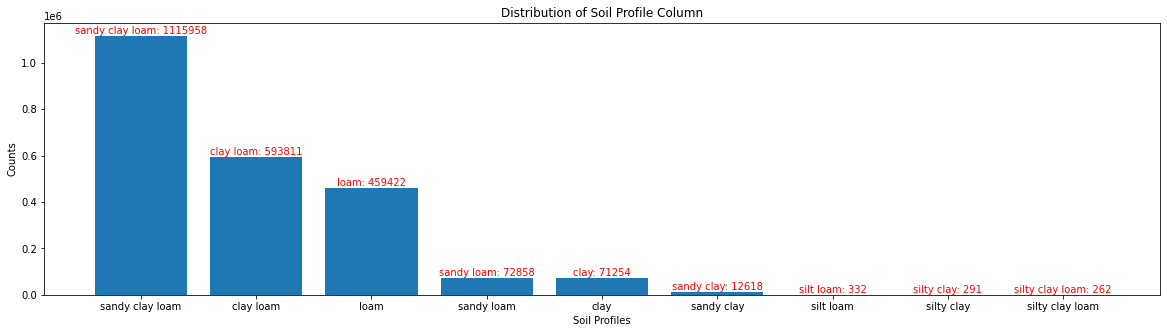

In [27]:
soil_profile = data_with_ecology["soil profile"].dropna().value_counts()
fig, ax = plt.subplots(1, 1, figsize=(20,5))

labels = list(soil_profile.index)

ax.bar(labels, list(soil_profile))
ax.set_ylabel("Counts")
ax.set_xlabel("Soil Profiles")

ax.set_title("Distribution of Soil Profile Column")

rects = ax.patches
counts = [int(x.get_height()) for x in rects]

for rect, label, count in zip(rects, labels, counts):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height+5, f"{label}: {count}",
            ha='center', va='bottom', color="red")
    
plt.show()

### Distribution of Soil Texture Vs Breeding

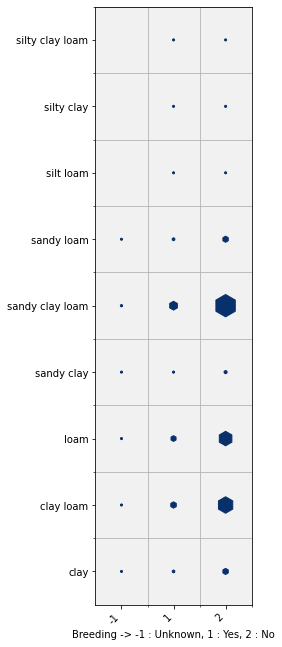

In [54]:
# breeding_vs_soil_profile = data_with_ecology.groupby(['BREEDING', 'soil profile']).count()[['X']].reset_index().replace(np.nan, 0)

plt.figure(figsize=(3, 11))
heatmap(
    x=breeding_vs_soil_profile['BREEDING'],
    y=breeding_vs_soil_profile['soil profile'],
    size=breeding_vs_soil_profile['X'],
    marker='h',
)
plt.xlabel("Breeding -> -1 : Unknown, 1 : Yes, 2 : No")
plt.show()

### Distribution of Soil Texture Vs Locust Present

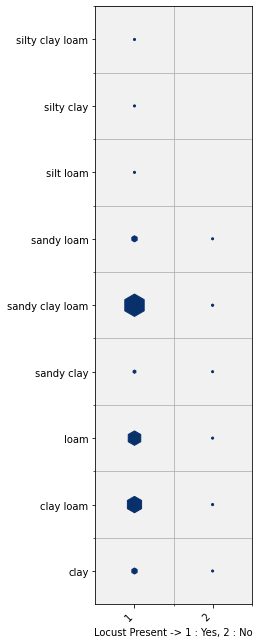

In [53]:
locust_vs_soil_profile = data_with_ecology.groupby(['LOCPRESENT', 'soil profile']).count()[['X']].reset_index().replace(np.nan, 0)

plt.figure(figsize=(3, 11))
heatmap(
    x=locust_vs_soil_profile['LOCPRESENT'],
    y=locust_vs_soil_profile['soil profile'],
    size=locust_vs_soil_profile['X'],
    marker='h',
)
plt.xlabel("Locust Present -> 1 : Yes, 2 : No")
plt.show()

## Yearly Distribution of Locust Observation

##### These plots show the number of swarms, hoppers and adults hoppers observed each year from 1985 - 2021

In [19]:
data_with_ecology['yearmonth']= data_with_ecology['STARTDATE'].dt.year*100+ data_with_ecology['STARTDATE'].dt.month
data_with_ecology['year']= data_with_ecology['STARTDATE'].dt.year
data_with_ecology['month']= data_with_ecology['STARTDATE'].dt.month

data_year_agg = data_with_ecology.groupby(['year']).agg(
    Count      = ('CAT', len),
    Swarm      = ('CAT', lambda col: sum(col=='Swarm')),
    Adult      = ('CAT', lambda col: sum(col=='Adult')),
    Hopper     = ('CAT', lambda col: sum(col=='Hopper')),
)

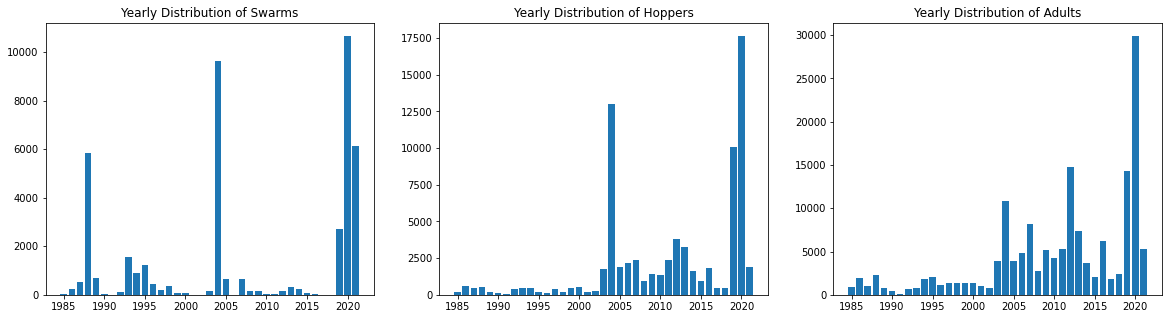

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(20,5))
axs = axs.flatten()

indices = list(data_year_agg.index)
axs[0].bar(indices, data_year_agg["Swarm"])
axs[0].set_title("Yearly Distribution of Swarms")

axs[1].bar(indices, data_year_agg["Hopper"])
axs[1].set_title("Yearly Distribution of Hoppers")

axs[2].bar(indices, data_year_agg["Adult"])
axs[2].set_title("Yearly Distribution of Adults")

plt.show()

## Correlation

In [22]:
integrity_columns = [ 
    'CONFIRMATN', 
    'REPRELIAB'
]

primary_columns =  [
    'AREAHA',
    'LOCPRESENT',
    'NATVEGCAT',
    'NATVEGDEN',
    'CULTVEGCAT',
    'SOILMOIST',
    'IRRIGATION',
    'BREEDING',
]

soil_texture_columns = [
    'clay_0-5cm_mean',
    'clay_5-15cm_mean',
    'sand_0-5cm_mean',
    'sand_5-15cm_mean',
    'silt_0-5cm_mean',
    'silt_5-15cm_mean'
]

secondary_columns_1 = [
    # solitary hopper density
    'SHPMINDSQM',
    'SHPMAXDSQM',
    'SHPMINDSIT',
    'SHPMAXDSIT',
    'SHPDENISOL',
    'SHPDENSCAT',
    'SHPDENGRP',
    'SHPDENUNK',
    # gregarious hopper density
    'GHPMINDSQM',
    'GHPMAXDSQM',
    'GHPMINDSIT',
    'GHPMAXDSIT',
    'GHPDENLOW',
    'GHPDENMED',
    'GHPDENHI',
    'GHPDENUNK',
    # solitarious adult density
    'SADMINDHA',
    'SADMAXDHA',
    'SADDENISOL',
    'SADDENSCAT',
    'SADDENGRP',
    'SADDENUNK',
]

secondary_columns_2 = [
    # solitary hopper maturity
    'SHPMATEGG',
    'SHPMATHAT',
    'SHPMATINS1',
    'SHPMATINS2',
    'SHPMATINS3',
    'SHPMATINS4',
    'SHPMATINS5',
    'SHPMATINS6',
    'SHPMATFLED',
    'SHPMATUNK',
    # solitary hopper appearance
    'SHPAPPSOL',
    'SHPAPPTRAN',
    'SHPAPPGREG',
    'SHPAPPUNK',
    # gregarious hopper maturity
    'GHPMATEGG',
    'GHPMATHAT',
    'GHPMATINS1',
    'GHPMATINS2',
    'GHPMATINS3',
    'GHPMATINS4',
    'GHPMATINS5',
    'GHPMATINS6',
    'GHPMATFLED',
    'GHPMATUNK',
    # gregarioius hopper area
    'GHPMINAHA',
    'GHPMAXAHA',
    'GHPARVSML',
    'GHPARSML',
    'GHPARMED',
    'GHPARLGE',
    'GHPARVLGE',
    'GHPARUNK',
    # gregarious adult maturity
    'GADMATIMMA',
    'GADMATMATG',
    'GADMATMAT',
    'GADMATCOP',
    'GADMATLAY',
    'GADMATUNK',
    # gregarious adult area
    'GADMINASKM',
    'GADMAXASKM',
    'GADARVSML',
    'GADARSML',
    'GADARMED',
    'GADARLGE',
    'GADARVLGE',
    'GADARUNK',
    # gregarious adults flying info
    'GADFLYFROM',
    'GADFLYTO',
    'GADHTLOW',
    'GADHTMED',
    'GADHTHI',
    'GADHTUNK',
    # control date
    'CTLEXACT',
    'CTLPTMONTH',
    # control pesticide
    'CTLPESTIC',
    'CTLAPPRAT',
    'CTLQTY',
    'CTLARTREA',
    # control application type
    'CTLAPPHAND',
    'CTLAPPVEHI',
    'CTLAPPAIR',
    'CTLAPPMECH',
    'CTLAPPUNK',
    # control estimated mortality
    'CTLESTKILL',
]

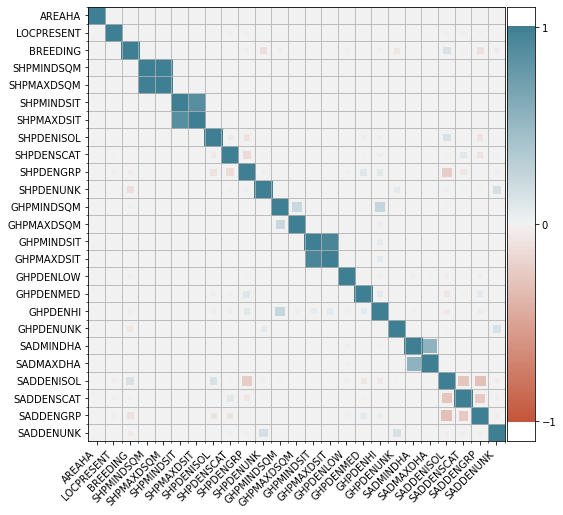

In [23]:
data_ = data_with_ecology[primary_columns+secondary_columns_1]
plt.figure(figsize=(8, 8))
corrplot(data_.corr(), size_scale=300);

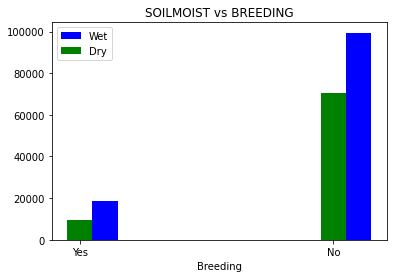

In [24]:
breeding_counts = {}
for breeding in data_with_ecology["BREEDING"].unique():
    data = data_with_ecology[data_with_ecology["BREEDING"] == breeding]
    breeding_counts[breeding] = list(data["SOILMOIST"].value_counts())
    
fig, ax = plt.subplots(1, 1)

indices = np.array([1, 2])
y1 = [breeding_counts[v][0] for v in indices]
y2 = [breeding_counts[v][1] for v in indices]

w = 0.1

ax.bar(indices+w, y1, width=w, color='b', align='center', label="Wet")
ax.bar(indices, y2, width=w, color='g', align='center', label="Dry")
ax.set_xlabel("Counts")
ax.set_xlabel("Breeding")
ax.set_xticks(indices)
ax.set_xticklabels(["Yes", "No"])
ax.legend()

ax.set_title("SOILMOIST vs BREEDING")

plt.show()

## Data Statistics and Schema

#### Variables from Ecology have about 19% missing values.

In [28]:
stats_options = tfdv.StatsOptions(feature_allowlist=primary_columns + soil_texture_columns + secondary_columns_1 + secondary_columns_2)
data_stats = tfdv.generate_statistics_from_dataframe(data_with_ecology, stats_options)
schema = tfdv.infer_schema(data_stats)

### Statistics of Columns in Data

In [29]:
tfdv.visualize_statistics(data_stats)

### Schema of Columns in Data

In [30]:
tfdv.display_schema(schema)

,Type,Presence,Valency,Domain
Feature name,,,,
'AREAHA',FLOAT,required,,-
'LOCPRESENT',INT,required,,-
'BREEDING',INT,required,,-
'SHPMINDSQM',FLOAT,required,,-
'SHPMAXDSQM',FLOAT,required,,-
...,...,...,...,...
'SOILMOIST',STRING,optional,single,'SOILMOIST'
'NATVEGCAT',STRING,optional,single,'NATVEGCAT'
'NATVEGDEN',STRING,optional,single,'NATVEGDEN'


/opt/conda/lib/python3.8/site-packages/tensorflow_data_validation/utils/display_util.py:180: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


,Values
Domain,
'SOILMOIST',"'Dry', 'Unknown', 'Wet'"
'NATVEGCAT',"'Dry', 'Drying', 'Green', 'Greening', 'Unknown'"
'NATVEGDEN',"'Dense', 'Moderate', 'Sparse', 'Unknown'"
'CULTVEGCAT',"'Dry', 'Drying', 'Green', 'Greening', 'Unknown'"
'IRRIGATION',"'No', 'Unknown', 'Yes'"


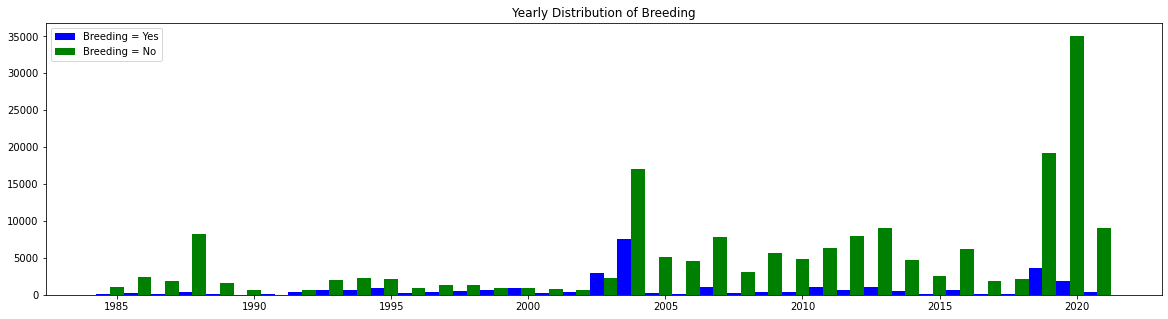

In [124]:
fig, ax = plt.subplots(1, 1, figsize=(20,5))

indices =  fao_data_year_agg.index
y1 = fao_data_year_agg["BREEDING_yes"]
y2 = fao_data_year_agg["BREEDING_no"]
w = 0.5

ax.bar(indices-w, y1, width=w, color='b', align='center', label="Breeding = Yes")
ax.bar(indices, y2, width=w, color='g', align='center', label="Breeding = No")
ax.legend()

ax.set_title("Yearly Distribution of Breeding")

plt.show()

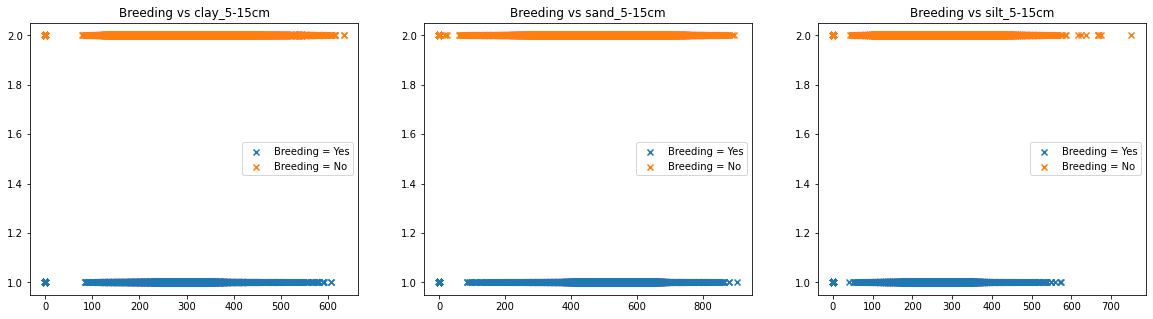

In [125]:
fig, axs = plt.subplots(1, 3, figsize=(20,5))
axs = axs.flatten()

breeding_yes = fao_data[fao_data["BREEDING"] == 1]
breeding_no = fao_data[fao_data["BREEDING"] == 2]

for data, ax in zip(["clay", "sand", "silt"], axs):
    ax.scatter(breeding_yes[f"{data}_5-15cm_mean"], breeding_yes["BREEDING"], marker="x", label="Breeding = Yes")
    ax.scatter(breeding_no[f"{data}_5-15cm_mean"], breeding_no["BREEDING"], marker="x", label="Breeding = No")
    ax.set_title(f"Breeding vs {data}_5-15cm")
    ax.legend()

plt.show()

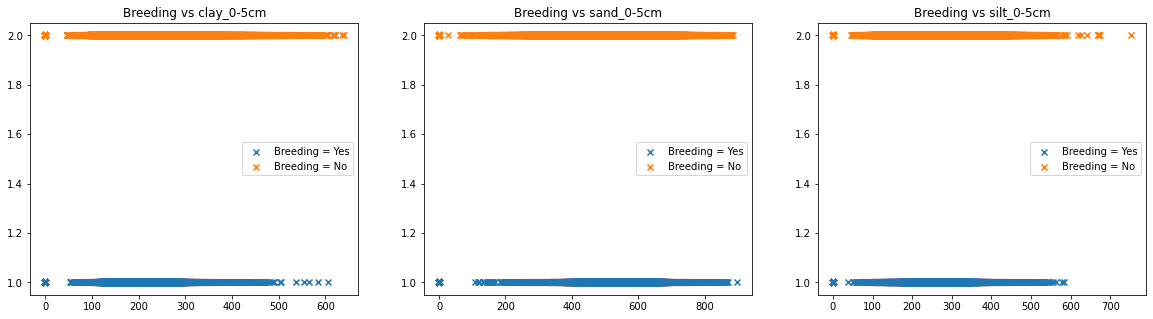

In [126]:
fig, axs = plt.subplots(1, 3, figsize=(20,5))
axs = axs.flatten()

breeding_yes = fao_data[fao_data["BREEDING"] == 1]
breeding_no = fao_data[fao_data["BREEDING"] == 2]

for data, ax in zip(["clay", "sand", "silt"], axs):
    ax.scatter(breeding_yes[f"{data}_0-5cm_mean"], breeding_yes["BREEDING"], marker="x", label="Breeding = Yes")
    ax.scatter(breeding_no[f"{data}_0-5cm_mean"], breeding_no["BREEDING"], marker="x", label="Breeding = No")
    ax.set_title(f"Breeding vs {data}_0-5cm")
    ax.legend()

plt.show()

In [ ]:
resx, resy = (0.01, 0.01)

lat_to_bucket_id = lambda x: int((x+90)/resy)
lon_to_bucket_id = lambda x: int((x+180)/resx)

bucket_id_to_lat = lambda x: (x*resy) - 90
bucket_id_to_lon = lambda x: (x*resx) - 180

In [106]:
#Replacing specific lat and lon of each row of data with its corresponding bucket_id

moisture_data = fao_data.copy()
moisture_data['lat_bucket_id'] = fao_data['Y'].apply(lat_to_bucket_id)
moisture_data['lon_bucket_id'] = fao_data['X'].apply(lon_to_bucket_id)

NameError: name 'lat_to_bucket_id' is not defined

In [107]:
moisture_data = moisture_data.groupby(['yearmonth','lat_bucket_id','lon_bucket_id']).agg(
# meta data
    TIME = ('STARTDATE', lambda col: col.mean()), 

# data count
    Count      = ('CAT', len),
    Swarm      = ('CAT', lambda col: sum(col=='Swarm')),
    Adult      = ('CAT', lambda col: sum(col=='Adult')),
    Hopper     = ('CAT', lambda col: sum(col=='Hopper')),
    Ecology    = ('CAT', lambda col: sum(col=='Ecology')),

# Ecology data count
    # NATVEGCAT___Ecology
    NATVEGCAT_Green    = ('NATVEGCAT', lambda col: sum(col=='Green')), 
    NATVEGCAT_Drying   = ('NATVEGCAT', lambda col: sum(col=='Drying')), 
    NATVEGCAT_Dry      = ('NATVEGCAT', lambda col: sum(col=='Dry')), 
    NATVEGCAT_Greening = ('NATVEGCAT', lambda col: sum(col=='Greening')), 

    # NATVEGDEN___Ecology
    NATVEGDEN_Moderate = ('NATVEGDEN', lambda col: sum(col=='Moderate')),
    NATVEGDEN_Sparse   = ('NATVEGDEN', lambda col: sum(col=='Sparse')), 
    NATVEGDEN_Dense    = ('NATVEGDEN', lambda col: sum(col=='Dense')), 

    # SOILMOIST___Ecology
    SOILMOIST_Dry      = ('SOILMOIST', lambda col: sum(col=='Dry')),
    SOILMOIST_Wet      = ('SOILMOIST', lambda col: sum(col=='Wet')),

    # BREEDING
    BREEDING_yes = ("BREEDING", lambda col: sum(col==1)),
    BREEDING_no = ("BREEDING", lambda col: sum(col==2)),
    BREEDING_na = ("BREEDING", lambda col: sum(col==-1)),
)

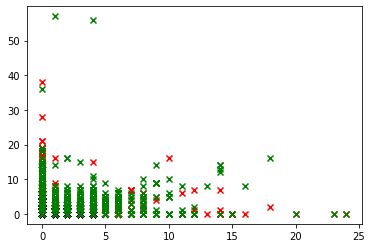

In [111]:
# moisture_data = fao_data[(fao_data["SOILMOIST"] == "Wet") | (fao_data["SOILMOIST"] == "Dry")]
# moisture_data["SOILMOIST_Binary"] = moisture_data["SOILMOIST"].map(lambda x: 1 if x=="Wet" else 0)

plt.scatter(moisture_data["BREEDING_yes"], moisture_data["SOILMOIST_Dry"], color="r", marker="x")
plt.scatter(moisture_data["BREEDING_yes"], moisture_data["SOILMOIST_Wet"], color="g", marker="x")

In [153]:
breeding_counts

{2: [99429, 70656], 1: [18654, 5288], -1: [50, 30]}

In [171]:
indices

array([[ 2,  1, -1]])

In [100]:
moisture_data["BREEDING"].unique()

array([nan])

In [101]:
fao_data["BREEDING"].unique()

array([nan,  2.,  1., -1.])

In [103]:
fao_data[(fao_data["BREEDING"] == 1) | (fao_data["BREEDING"] == 2)]["SOILMOIST"].unique()

array([nan], dtype=object)

In [96]:
moisture_data["SOILMOIST_Binary"].unique()

array([1, 0])

In [97]:
moisture_data["BREEDING"].unique()

array([nan])

In [122]:
columns = ['date', 'TIME', 'Count',
       'Swarm', 'Adult', 'Hopper', 'Ecology', 'NATVEGCAT_Green',
       'NATVEGCAT_Drying', 'NATVEGCAT_Dry', 'NATVEGCAT_Greening',
       'NATVEGDEN_Moderate', 'NATVEGDEN_Sparse', 'NATVEGDEN_Dense',
       'SOILMOIST_Dry', 'SOILMOIST_Wet', 'BREEDING_yes', 'BREEDING_no',
       'BREEDING_na', 'month', 'day', 'year', 'lat', 'lon', 'clay_0-5cm_mean',
       'clay_5-15cm_mean', 'sand_0-5cm_mean', 'sand_5-15cm_mean',
       'silt_0-5cm_mean', 'silt_5-15cm_mean']

columns = [
 'STARTDATE',
 'NATVEGCAT',
 'NATVEGDEN',
#  'CULTVEGCAT',
 'SOILMOIST',
#  'IRRIGATION',
 'BREEDING',
 'clay_0-5cm_mean',
 'clay_5-15cm_mean',
 'sand_0-5cm_mean',
 'sand_5-15cm_mean',
 'silt_0-5cm_mean',
 'silt_5-15cm_mean']

In [242]:
len(fao_data[fao_data["BREEDING"].isna()])/len(fao_data)

0.6689635571372744

In [239]:
col = "SHPDENGRP" 
col = "GHPMATINS1"

print(col in Adults.columns)
print(col in Hoppers.columns)
print(col in Swarms.columns)

True
True
True


In [25]:
fao_data["SOILMOIST_Wet"]

0         1
1         1
2         0
3         0
4         0
         ..
446090    0
446091    0
446092    0
446093    0
446094    0
Name: SOILMOIST_Wet, Length: 446095, dtype: int64

In [28]:
fao_data["BREEDING_na"].value_counts()

0.0    445611
1.0       461
2.0        20
3.0         3
Name: BREEDING_na, dtype: int64

In [30]:
fao_data[((fao_data["BREEDING_yes"] > 0.0) & (fao_data["BREEDING_no"] > 0.0) & (fao_data["BREEDING_na"] > 0.0))]

,Unnamed: 0,date,lat_bucket_id,lon_bucket_id,TIME,Count,Swarm,Adult,Hopper,Ecology,...,day,year,lat,lon,clay_0-5cm_mean,clay_5-15cm_mean,sand_0-5cm_mean,sand_5-15cm_mean,silt_0-5cm_mean,silt_5-15cm_mean


In [31]:
fao_data[((fao_data["BREEDING_na"] == fao_data["Count"]))]

,Unnamed: 0,date,lat_bucket_id,lon_bucket_id,TIME,Count,Swarm,Adult,Hopper,Ecology,...,day,year,lat,lon,clay_0-5cm_mean,clay_5-15cm_mean,sand_0-5cm_mean,sand_5-15cm_mean,silt_0-5cm_mean,silt_5-15cm_mean
16555,16555,1992-01-21 00:00:00+00:00,12173,19020,1992-01-21 00:00:00+00:00,1,0,1,0,0,...,21,1992,31.73,10.20,272.0,381.0,388.0,381.0,340.0,339.0
16609,16609,1992-04-11 00:00:00+00:00,12146,18976,1992-04-11 00:00:00+00:00,1,0,1,0,0,...,11,1992,31.46,9.76,284.0,229.0,363.0,365.0,353.0,343.0
16615,16615,1992-04-14 00:00:00+00:00,10980,16568,1992-04-14 00:00:00+00:00,1,0,1,0,0,...,14,1992,19.80,-14.32,133.0,0.0,632.0,635.0,235.0,237.0
16617,16617,1992-04-14 00:00:00+00:00,11018,16651,1992-04-14 00:00:00+00:00,1,0,1,0,0,...,14,1992,20.18,-13.49,171.0,0.0,561.0,566.0,268.0,267.0
16627,16627,1992-04-16 00:00:00+00:00,10986,16576,1992-04-16 00:00:00+00:00,1,0,1,0,0,...,16,1992,19.86,-14.24,122.0,0.0,648.0,651.0,230.0,230.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37603,37603,1999-10-11 00:00:00+00:00,11580,24986,1999-10-11 00:00:00+00:00,1,0,1,0,0,...,11,1999,25.80,69.86,267.0,287.0,527.0,521.0,206.0,207.0
37604,37604,1999-10-11 00:00:00+00:00,11675,24941,1999-10-11 00:00:00+00:00,1,0,1,0,0,...,11,1999,26.75,69.41,272.0,323.0,554.0,551.0,175.0,175.0
37605,37605,1999-10-11 00:00:00+00:00,11761,24965,1999-10-11 00:00:00+00:00,1,0,1,0,0,...,11,1999,27.61,69.65,211.0,337.0,579.0,576.0,210.0,216.0
37614,37614,1999-10-12 00:00:00+00:00,11838,25130,1999-10-12 00:00:00+00:00,1,0,1,0,0,...,12,1999,28.38,71.30,235.0,347.0,521.0,517.0,245.0,244.0


In [114]:
ax.hist(fao_data["BREEDING"])

(array([   510.,      0.,      0.,      0.,      0.,      0.,  29539.,
             0.,      0., 184263.]),
 array([-1. , -0.7, -0.4, -0.1,  0.2,  0.5,  0.8,  1.1,  1.4,  1.7,  2. ]),
 <BarContainer object of 10 artists>)

In [ ]:
resx, resy = (0.01, 0.01)

lat_to_bucket_id = lambda x: int((x+90)/resy)
lon_to_bucket_id = lambda x: int((x+180)/resx)

bucket_id_to_lat = lambda x: (x*resy) - 90
bucket_id_to_lon = lambda x: (x*resx) - 180

In [ ]:
#Replacing specific lat and lon of each row of data with its corresponding bucket_id

discretize_time  = lambda x: datetime.date(year=x.year, month=x.month, day=1)

truncated_data = fao_data.copy()
truncated_data['lat_bucket_id'] = fao_data['Y'].apply(lat_to_bucket_id)
truncated_data['lon_bucket_id'] = fao_data['X'].apply(lon_to_bucket_id)

truncated_data['date'] = fao_data['STARTDATE'].apply(discretize_time).astype('datetime64[ns]')
truncated_data["year"] = fao_data['STARTDATE'].dt.year
truncated_data["month"] = fao_data['STARTDATE'].dt.month_name()

In [ ]:
aggregate_data = truncated_data.groupby(['date','lat_bucket_id','lon_bucket_id']).agg(
# meta data
    TIME = ('STARTDATE', lambda col: col.mean()), 

# data count
    Count      = ('CAT', len),
    Swarm      = ('CAT', lambda col: sum(col=='Swarm')),
    Adult      = ('CAT', lambda col: sum(col=='Adult')),
    Hopper     = ('CAT', lambda col: sum(col=='Hopper')),
    Ecology    = ('CAT', lambda col: sum(col=='Ecology')),

# Ecology data count
    # NATVEGCAT___Ecology
    NATVEGCAT_Green    = ('NATVEGCAT', lambda col: sum(col=='Green')), 
    NATVEGCAT_Drying   = ('NATVEGCAT', lambda col: sum(col=='Drying')), 
    NATVEGCAT_Dry      = ('NATVEGCAT', lambda col: sum(col=='Dry')), 
    NATVEGCAT_Greening = ('NATVEGCAT', lambda col: sum(col=='Greening')), 

    # NATVEGDEN___Ecology
    NATVEGDEN_Moderate = ('NATVEGDEN', lambda col: sum(col=='Moderate')),
    NATVEGDEN_Sparse   = ('NATVEGDEN', lambda col: sum(col=='Sparse')), 
    NATVEGDEN_Dense    = ('NATVEGDEN', lambda col: sum(col=='Dense')), 

    # SOILMOIST___Ecology
    SOILMOIST_Dry      = ('SOILMOIST', lambda col: sum(col=='Dry')),
    SOILMOIST_Wet      = ('SOILMOIST', lambda col: sum(col=='Wet')),

    # BREEDING
    BREEDING_yes = ("BREEDING", lambda col: sum(col==1)),
    BREEDING_no = ("BREEDING", lambda col: sum(col==2)),
    BREEDING_na = ("BREEDING", lambda col: sum(col==-1)),
)